#  Baseline model for TrackML competition using DBSCAN


Import the appropriate directories, both for the baseline evaluation and some plotting below

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
import os
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from trackml.score import score_event
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

After changing to the correct path directory, we populate hits and truths dataframes from their respective files.

In [12]:
truth_file = 'event000002461-truth.csv'
hits_file = 'event000002461-hits.csv'

truths = pd.read_csv(truth_file)
truths = truths.rename(columns={'tx':'x', 'ty':'y', 'tz':'z'})
truth_short = pd.DataFrame(truths, columns=['hit_id', 'particle_id'])

hits = pd.read_csv(hits_file)
hits_short = pd.DataFrame(hits, columns=['hit_id', 'x', 'y', 'z'])

Define a series of functions to perform preprocessing.  

The first of these will transform to a coordinate system that capitalizes on the natural geometry of the events (approximately circular in the x-y plane), then perform a standard scaling, which will zero the mean and normalize 
the variances.  This will effectively place tracks closer together with respect to other particles.

The following functions perform a track prediction for the various hits using DBSCAN and exporting the predictions
into a dataframe that labels event_id, hit_id, and predicted track_id.

In [13]:
def preprocess(data):
    
    ### {Dataframe} -> {3d array}
    ###
    ### Takes in a dataframe of stored hit position values, performs a coordinate transformation
    ### on those coordinates, and then applies the standard scaler (zeroing mean and normalizing variance).
    ###

    x = data['x'].values
    y = data['y'].values
    z = data['z'].values

    r = np.sqrt(x**2 + y**2)
    R = np.sqrt(x**2 + y**2 + z**2)

    data['X'] = x / R
    data['Y'] = y / R
    data['Z'] = z / r

    transformed_coordinates = StandardScaler().fit_transform(data[['X', 'Y', 'Z']])
    
    return transformed_coordinates

In [14]:
def predict(data):
    
    ### {Dataframe} -> {1d array}
    ###
    ### Takes in a dataframe of hit positions, transforms them via the preprocessing function, and \
    ### returns the labels predicted by the DBSCAN clustering algorithm.
    ###
    
    transformed_coords = preprocess(data)

    dbscan = DBSCAN(eps=0.008, min_samples=1, algorithm='auto')
    labels = dbscan.fit_predict(transformed_coords)
    
    return labels

In [15]:
def sample_evaluation(event_id, hits, labels):
    
    ### {number, dataframe, 1d array} -> {dataframe}
    ###
    ### Takes in event_id, hits dataframe, and labels from the predict function and returns
    ### an evaluated dataframe that lists the event_id, the hit_id, and the predicted label_id.
    ###
    
    submitted_info = np.column_stack(([event_id]*len(hits), hits.hit_id.values, labels))
    submission = pd.DataFrame(data=submitted_info, columns=["event_id", "hit_id", "track_id"])
    
    return submission

Utilizing the above functions, a prediction is generated and evaluated based on the truth labels.

In [16]:
labels = predict(hits)

In [17]:
submission = sample_evaluation(0, hits, labels)
score = score_event(truths, submission)

In [18]:
print("Score", score)

Score 0.19435186979572006


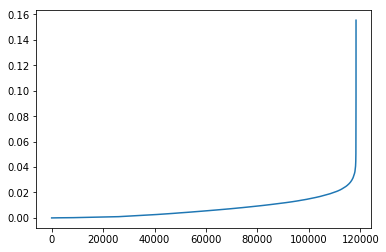

In [45]:
neigh = NearestNeighbors(n_neighbors=2)
neigh.fit(preprocess(hits))
distances, indices = neigh.kneighbors(preprocess(hits))
dist = distances[:,-1].tolist()
dist_sort = sorted(dist)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(indices[:, 0], dist_sort)
plt.show()

In [43]:
distances[:, -1].mean()

0.012257891647787775

Well, it's not the best score in the world, but it's not the worst either.  Note this really isn't a true baseline
score as it does not take into account our knowledge of the labels for our training data.  For that, look to the next notebook.

# A few plots for visualization

Visualizing the tracks in the untransformed vs transformed coordintes.

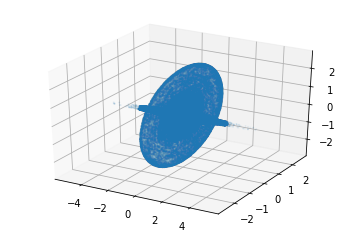

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x_vals = preprocess(hits_short)[:, 0]
y_vals = preprocess(hits_short)[:, 1]
z_vals = preprocess(hits_short)[:, 2]

ax.scatter(z_vals, x_vals, y_vals, s=1, alpha = 0.05)
plt.show();

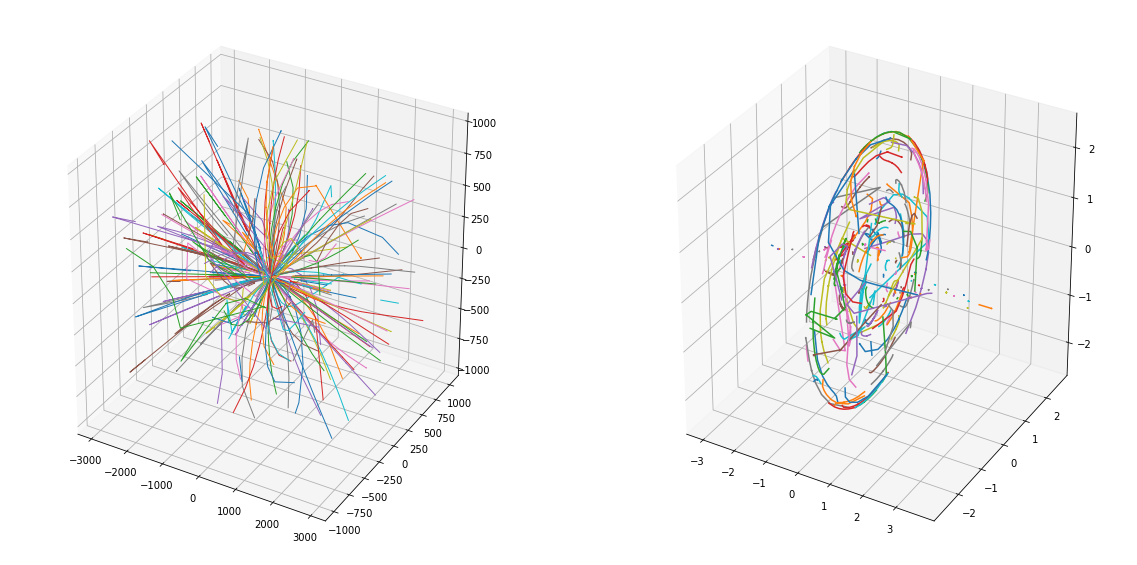

In [19]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121, projection='3d')

tracks = truths.particle_id.unique()

xt_vals = preprocess(hits_short)[:, 0]
yt_vals = preprocess(hits_short)[:, 1]
zt_vals = preprocess(hits_short)[:, 2]

for track in tracks[1::50]:
    t = truths[truths.particle_id == track]
    ax1.plot3D(t.z, t.x, t.y, lw=1)
    
ax2 = fig.add_subplot(122, projection='3d')
    
for track in tracks[1::50]:
    t = preprocess(truths)[truths.particle_id == track]
    ax2.plot3D(t[:,2], t[:,0], t[:,1])
    
plt.show()

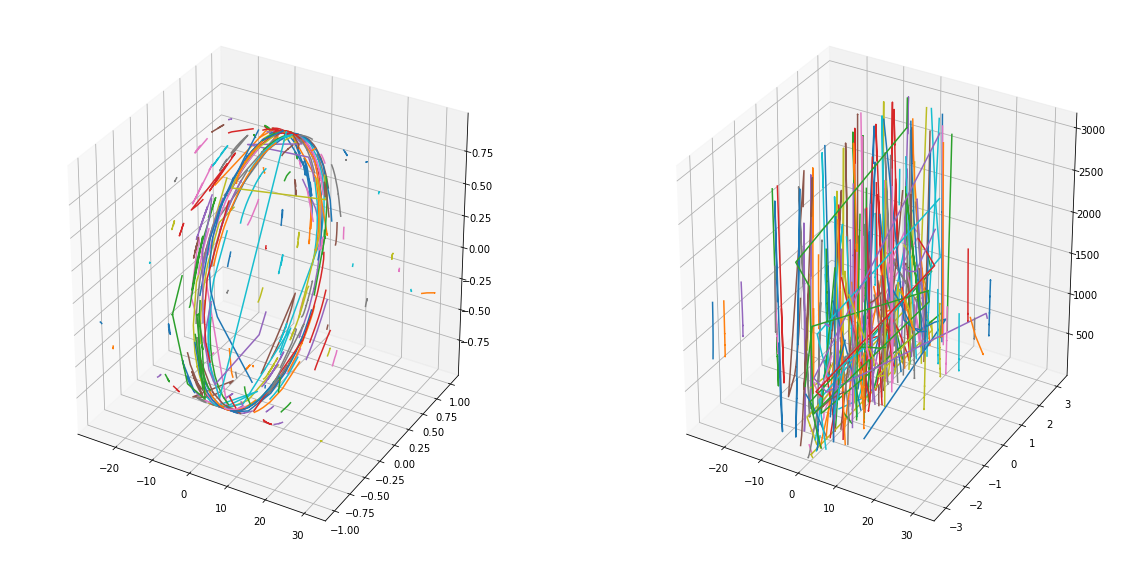

In [18]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121, projection='3d')

tracks = truths.particle_id.unique()

xt_vals = preprocess(hits_short)[:, 0]
yt_vals = preprocess(hits_short)[:, 1]
zt_vals = preprocess(hits_short)[:, 2]

for track in tracks[1::50]:
    t = truths[truths.particle_id == track]
    r = np.sqrt(t.x**2 + t.y**2)
    R = np.sqrt(t.x**2 + t.y**2 + t.z**2)
    
    tzz = t.z / r
    theta = np.arctan2(t.y, t.x)
    
    ax1.plot3D(tzz, np.cos(theta), np.sin(theta))
    
ax2 = fig.add_subplot(122, projection='3d')

for track in tracks[1::50]:
    t = truths[truths.particle_id == track]
    r = np.sqrt(t.x**2 + t.y**2)
    R = np.sqrt(t.x**2 + t.y**2 + t.z**2)
    
    tzz = t.z / r
    theta = np.arctan2(t.y, t.x)

    ax2.plot3D(tzz, theta, R)

plt.show()

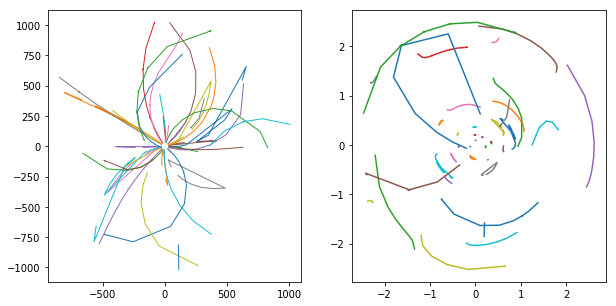

In [20]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)

for track in tracks[1::250]:
    t = truths[truths.particle_id == track]
    ax1.plot(t.x, t.y, lw=1)
    
ax2 = fig.add_subplot(122)
    
for track in tracks[1::250]:
    t = preprocess(truths)[truths.particle_id == track]
    ax2.plot(t[:,0], t[:,1])
    
plt.show()

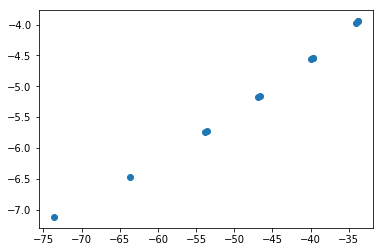

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
t = truths[truths.particle_id == 148622292396539904]
ax.scatter(t.x, t.y)
plt.show()

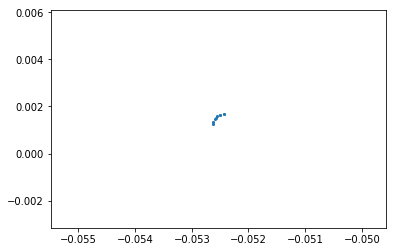

In [66]:
fig = plt.figure()
ax = fig.add_subplot(111)
t = truths[truths.particle_id == 126102232675385344]
r = np.sqrt(t.x**2 + t.y**2 + t.z**2)
ax.scatter(t.x / r, t.y / r, s=3)
plt.show()

Notice that when plotted as a function of cos(theta) and sin(theta), this forms a horizontal line in the xy plane.

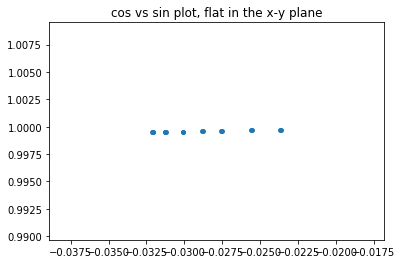

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
t = truths[truths.particle_id == 126102232675385344]
r = np.sqrt(t.x**2 + t.y**2 + t.z**2)
theta = np.arctan(t.y / t.x)
ax.scatter(np.sin(theta), np.cos(theta), s=15)
plt.title('cos vs sin plot, flat in the x-y plane')
plt.show()

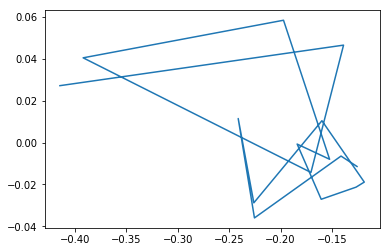

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
t = truths[truths.particle_id == 126102232675385344]
    
x = truths['x'].values
y = truths['y'].values
z = truths['z'].values

r = np.sqrt(x**2 + y**2)
R = np.sqrt(x**2 + y**2 + z**2)

truths['X'] = x / R
truths['Y'] = y / R
truths['Z'] = z / r

transformed_coordinates = StandardScaler().fit_transform(truths[['X', 'Y', 'Z']])

hit_ids = np.array(truths[truths.particle_id == 126102232675385344].hit_id)

plt.plot(transformed_coordinates[hit_ids, 0], transformed_coordinates[hit_ids, 1]);
